In [1]:
import cv2
import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial import cKDTree
from scipy.stats import binom
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

In [2]:
class FeatureExtractor:
    def __init__(self, n_components = 40):
        self.n_components = n_components
        self.gabor_kernels = self._create_gabor_kernels()

    def _create_gabor_kernels(self):
        gabor_kernels = []
        frequencies = [0.1, 0.2, 0.4, 0.8]
        orientations = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]
        for freq in frequencies:
            for theta in orientations:
                kernel = cv2.getGaborKernel((21, 21), 4.0, theta, freq, 1.0, 0, cv2.CV_32F)
                gabor_kernels.append(kernel)
        return gabor_kernels

    def extract_features(self, image):
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        features = []
        for kernel in self.gabor_kernels:
            filtered_image = cv2.filter2D(gray_image, cv2.CV_8UC3, kernel)
            laplacian_response = cv2.Laplacian(filtered_image, cv2.CV_64F)
            #features.append(laplacian_response.mean())
            features.append(laplacian_response)
            
            plt.imshow(filtered_image, cmap='gray')
            plt.show()
            plt.imshow(laplacian_response, cmap='gray')
            plt.show()
        features = np.array(features)
        return features
    
    def fit_pca(self, template_features):
        self.pca = PCA(n_components = self.n_components)
        print(template_features.shape)
        compressed_features = self.pca.fit_transform(template_features)
        return compressed_features

    def transform_feature(self, feature):
        compressed_feature = self.pca.transform(feature)
        return compressed_feature.flatten()

In [3]:
feature_extractor = FeatureExtractor()

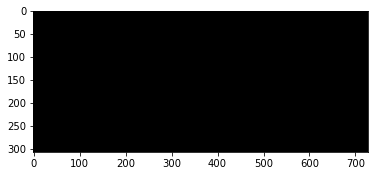

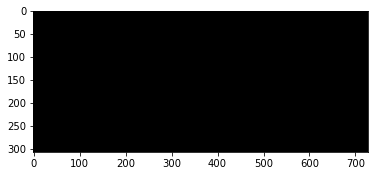

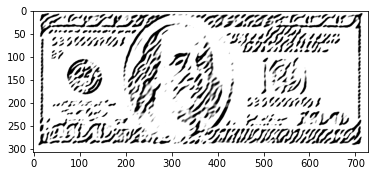

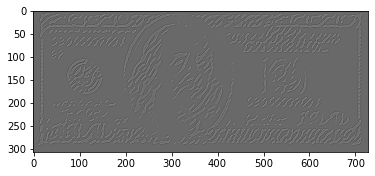

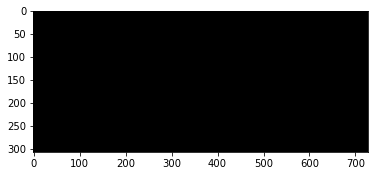

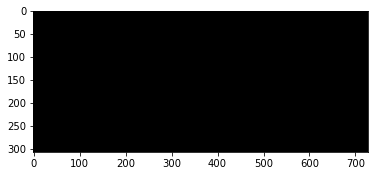

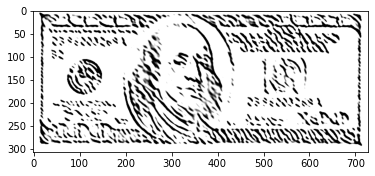

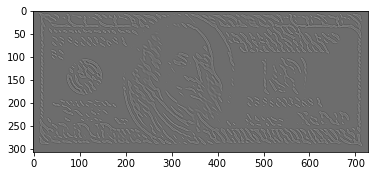

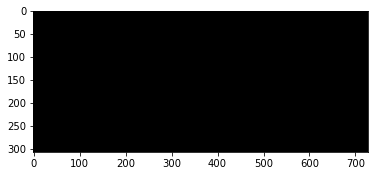

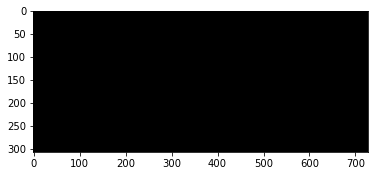

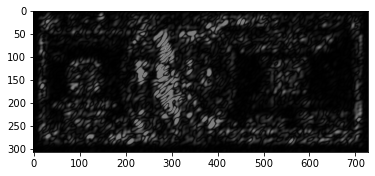

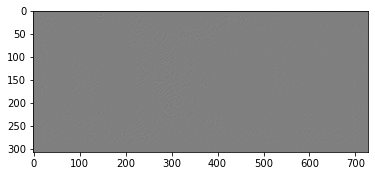

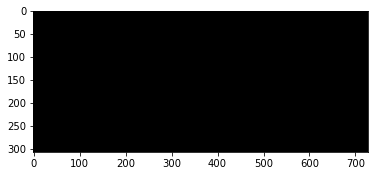

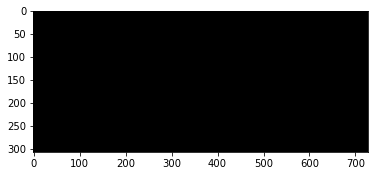

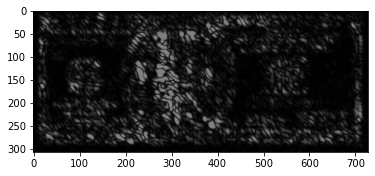

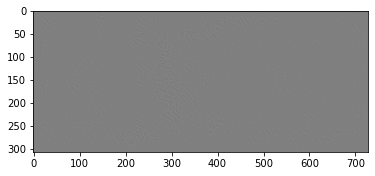

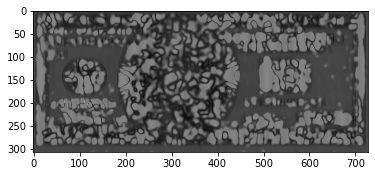

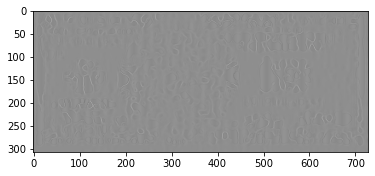

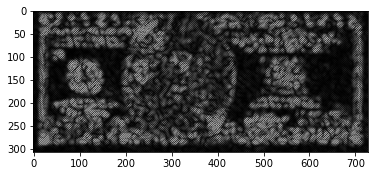

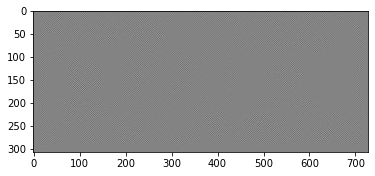

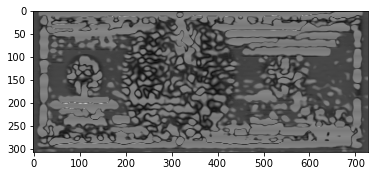

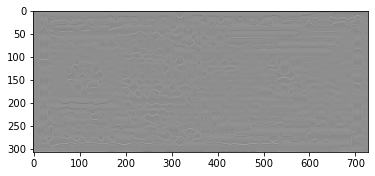

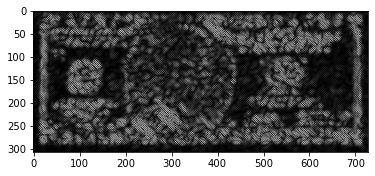

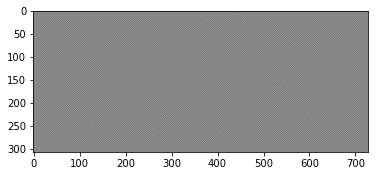

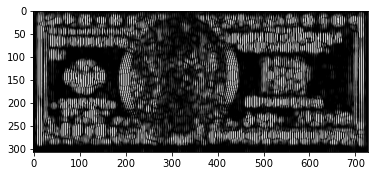

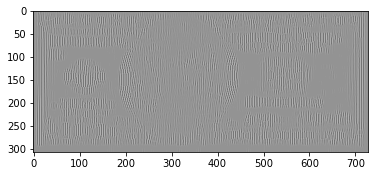

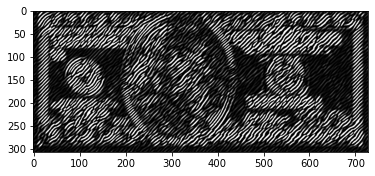

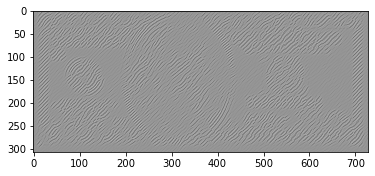

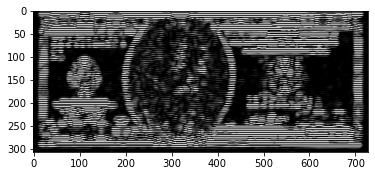

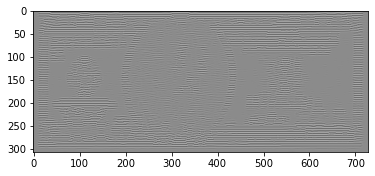

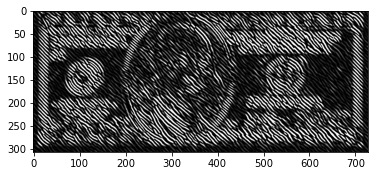

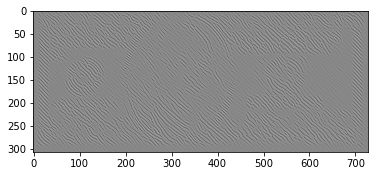

In [4]:
image_path = '1.jpg'
image = cv2.imread(image_path)
features = feature_extractor.extract_features(image)

In [5]:
print(features.shape)

(16, 307, 728)


In [6]:
#features

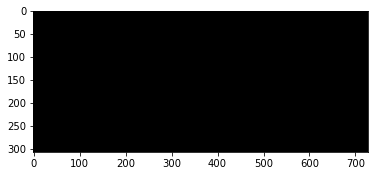

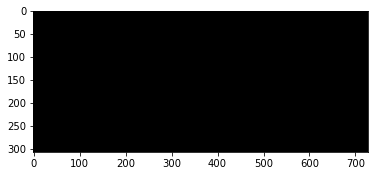

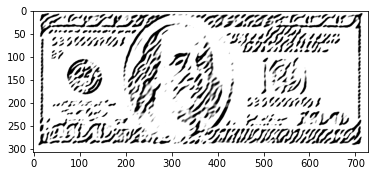

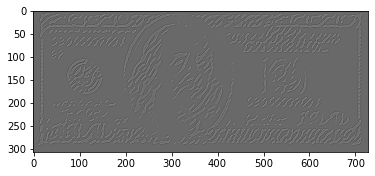

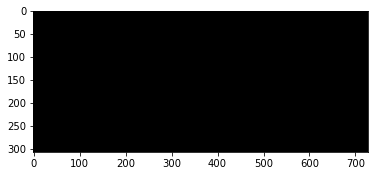

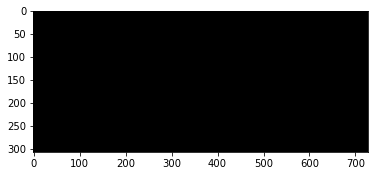

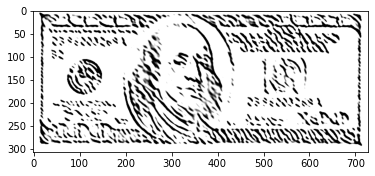

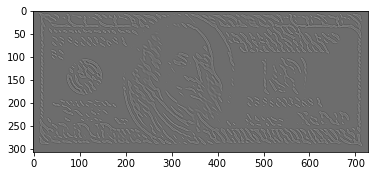

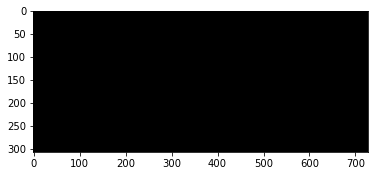

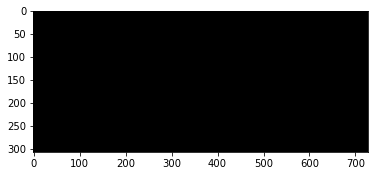

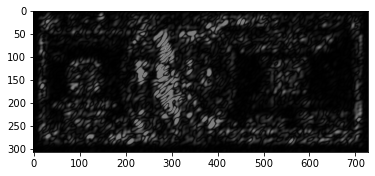

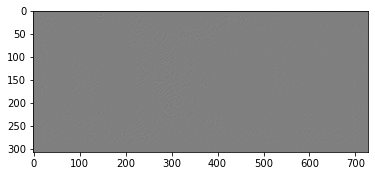

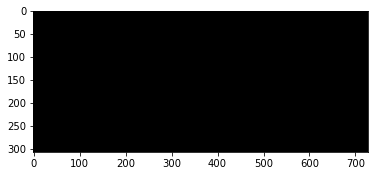

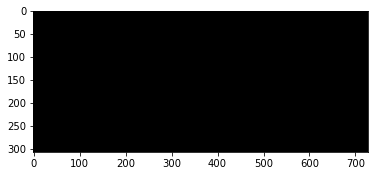

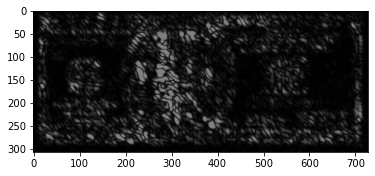

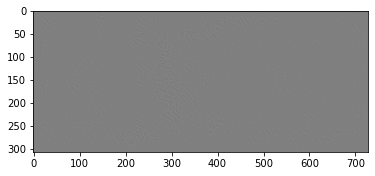

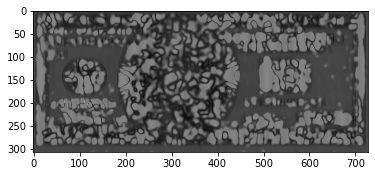

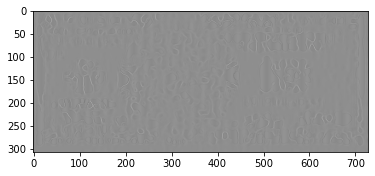

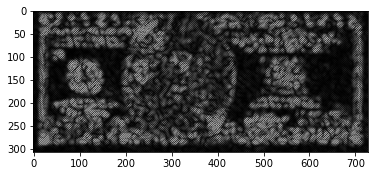

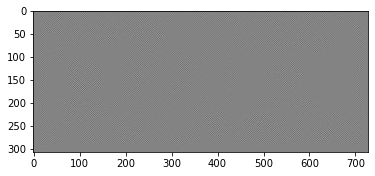

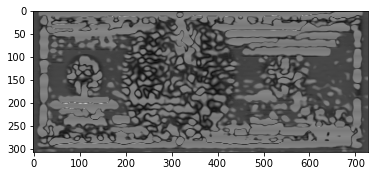

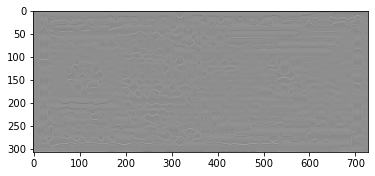

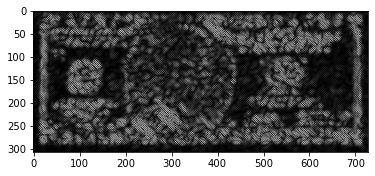

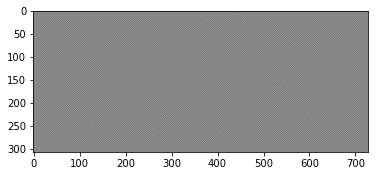

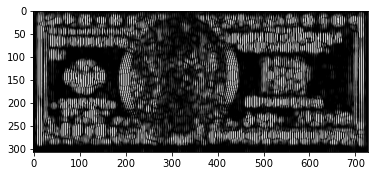

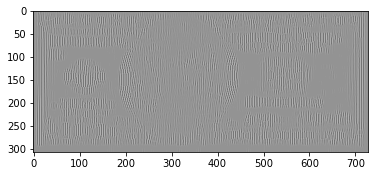

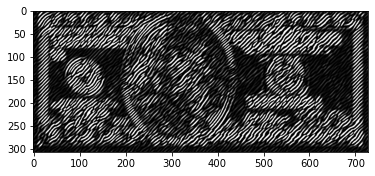

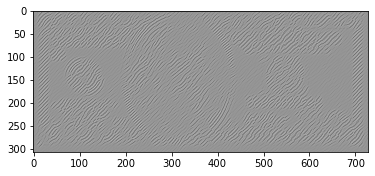

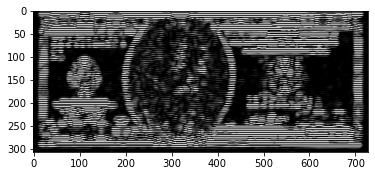

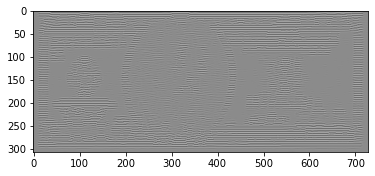

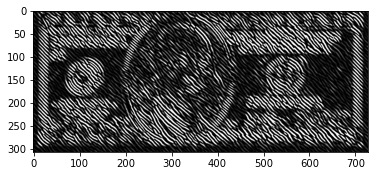

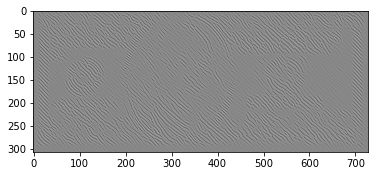

In [7]:
query_image_path = '2.jpg'
query_image = cv2.imread(image_path)
query_features = feature_extractor.extract_features(image)

In [8]:
class FeatureMatcher:
    def __init__(self, index_builder):
        self.index_builder = index_builder

    def match_features(self, query_feature):
        dist, idx = self.index_builder.search(query_feature)
        return dist, idx

In [9]:
class SpatialMatcher:
    def __init__(self, min_matches=3, k=3):
        self.min_matches = min_matches
        self.k = k
        self.sift = cv2.xfeatures2d.SIFT_create()

    def cluster_matches(self, matches, keypoints1, keypoints2):
        query_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        train_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
        _, mask = cv2.findHomography(query_pts, train_pts, cv2.RANSAC, 5.0)
        return mask

In [133]:
class IndexBuilder:
    def __init__(self, features):
        self.features = features
        self.kd_tree = self._build_kd_tree(features)

    def _build_kd_tree(self, features):
        reshaped_features = features.reshape(features.shape[0], -1)
        return cKDTree(reshaped_features)

    def search(self, query_features):
        reshaped_query_features = query_features.reshape(1, -1)
        distances, indices = self.kd_tree.query(reshaped_query_features, k=3)
        return distances.flatten(), indices.flatten()

    def prune_common_patterns(self):
        matches = []
        for i, template_features in enumerate(self.features):
            indices = self._match_features(template_features)
            matches.append(indices)

        remove_indices = np.concatenate(matches, axis=0)
        remove_indices = np.unique(remove_indices)

        mask = np.ones(self.features.shape[0], dtype=bool)
        mask[remove_indices] = False

        self.features = self.features[mask]
        self.kd_tree = self._build_kd_tree(self.features)

    def _match_features(self, features):
        distances = np.linalg.norm(self.features - features, axis=0)  # Calculate L2-norm distance
        indices = np.argsort(distances)[:3]  # Top 3 closest matches
        return indices

In [134]:
# Index building
index_builder = IndexBuilder(features)

In [135]:
index_builder.kd_tree.data.shape

(16, 223496)

# From here we have to work

In [136]:
index_builder.prune_common_patterns()

IndexError: index 16 is out of bounds for axis 0 with size 16

In [140]:
index_builder.kd_tree.data.shape

(16, 223496)

In [141]:


class MatcherScorer:
    def __init__(self):
        self.prior_probability = None

    def compute_prior_probability(self, num_template_features, num_query_features, num_index_features):
        p = (num_template_features * num_query_features) / num_index_features
        return p

    def compute_cluster_probability(self, k, n, p):
        cluster_prob = binom.cdf(k, n, p)
        return cluster_prob

    def compute_score(self, clusters, num_template_features, num_index_features):
        scores = []
        for cluster in clusters:
            n = len(cluster)
            p = self.compute_prior_probability(num_template_features, n, num_index_features)
            max_prob = np.max(1 - self.compute_cluster_probability(n, num_template_features, p))
            scores.append(max_prob)
        return scores

# Example usage
# Assuming you have template_images and query_image

# Feature extraction
extractor = FeatureExtractor()
template_features = np.array([extractor.extract_features(template_image) for template_image in template_images])
query_feature = extractor.extract_features(query_image)

# Index building
index_builder = IndexBuilder(template_features)

# Feature matching
matcher = FeatureMatcher(index_builder)
distances, indices = matcher.match_features(query_feature)

# Spatial matching
spatial_matcher = SpatialMatcher()
clusters = spatial_matcher.cluster_matches(indices)

# Ranking
matcher_scorer = MatcherScorer()
scores = matcher_scorer.compute_score(clusters, len(template_features), len(index_builder.features))

# Sort the results based on scores
results = list(zip(scores, template_images))
results.sort(reverse=True)

# Retrieve the highest scoring template image for each query
for i, (score, query_image) in enumerate(zip(scores, query_images)):
    highest_score, best_template_image = results[i]
    print(f"Query image {i+1}: Best template image: {best_template_image}, Score: {highest_score}")


TypeError: __init__() missing 1 required positional argument: 'gabor_kernels'

In [ ]:
def print_kd_tree(self, node, depth = 0):
        if len(node) == 0:
            return

        for point in node:
            print("  " * depth, point)

        # Split points into halves based on the maximum coordinate axis
        axis = depth % len(node[0])
        split = np.median(node[:, axis])
        left_node = node[node[:, axis] < split]
        right_node = node[node[:, axis] >= split]

        self.print_kd_tree(left_node, depth + 1)
        self.print_kd_tree(right_node, depth + 1)